<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/22_imagenet_tiny_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tiny ImageNet**

In this notebook we will be building on what has been developed so far, with respect to the Stable Diffusion pipeline. In particular, the focus will be on training a super resolution UNet using the `Tiny ImageNet` dataset. Note that `Fashion MNIST` won't be used here due to its 28x28 image resolution, whereas the ImageNet images are 64x64.

In [ ]:
! git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1176 (delta 319), reused 294 (delta 294), pack-reused 795 (from 1)
Receiving objects: 100% (1176/1176), 98.57 MiB | 36.85 MiB/s, done.
Resolving deltas: 100% (714/714), done.


In [ ]:
! pip install k_diffusion datasets fastcore fastai fastprogress torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Su

In [ ]:
import os, shutil, timm, torch, random, datasets, math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K
import torchvision.transforms as T
import torchvision.transforms.functional as TF, torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob # unix style pathname pattern expansion

In [ ]:
from course22p2.miniai.datasets import *
from course22p2.miniai.conv import *
from course22p2.miniai.learner import *
from course22p2.miniai.activations import *
from course22p2.miniai.init import *
from course22p2.miniai.sgd import *
from course22p2.miniai.resnet import *
from course22p2.miniai.augment import *
from course22p2.miniai.accel import *
from course22p2.miniai.training import *

In [ ]:
from fastprogress import progress_bar

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Data Processing**

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [ ]:
# Note, tiny imagenet isn't widely available, but is still retained by Stanford.
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [ ]:
bs = 512

In [ ]:
# Simple class to create a dataset
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        # Pass specification of files to search
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        # Return a tuple of items and the titles
        return self.files[i], Path(self.files[i]).parent.parent.name

In [ ]:
tds = TinyDS(path/'train')
tds[0]

('data/tiny-imagenet-200/train/n02480495/images/n02480495_157.JPEG',
 'n02480495')

Note that the directory is structured as follows: `train/*category code*/images/....JPEG`.

The validation dataset isn't organized into subdirectories which match the training data. Specifically, there is a `val_annotations.txt` file which contains the necessary data for images and their categories. So additional data processing is required on this front.

In [ ]:
# Process val_annotations.txt file
path_anno = path/'val'/'val_annotations.txt'
# Create dict using a generator comprehension, split on tab and grab the first two cols
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [ ]:
print(path_anno.read_text()[:190])

val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48
val_5.JPEG	n04399382	7	0	59	63



In [ ]:
# Create inherited class to handle the validation data's different labelling approach.
# Here the label won't be the parent.parent name - instead, it will be the name of the file.
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i], anno[os.path.basename(self.files[i])]

In [ ]:
vds = TinyValDS(path/'val')

In [ ]:
vds[0], len(tds)

(('data/tiny-imagenet-200/val/images/val_7755.JPEG', 'n02132136'), 100000)

In [ ]:
# Now we need to create a generic class which can transform any dataset. We can pass the
# x or y i.e. independent and dependent variables. __init__() defaults to no-operation.
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x, y = self.ds[i]
        return self.tfmx(x), self.tfmy(y)

In [ ]:
# The dataset also provides a wordnet ID file, with 200 cat codes.
# We will change the coding from its original form to an int.
id2str = (path/'wnids.txt').read_text().splitlines()
# Inverted enumeration
str2id = {v:k for k, v in enumerate(id2str)}

In [ ]:
from itertools import islice

dict(islice(str2id.items(), 0, 5))

{'n02124075': 0,
 'n04067472': 1,
 'n04540053': 2,
 'n04099969': 3,
 'n07749582': 4}

In [ ]:
# Copying over xmean and xstd values of a batch for transformations
xmean, xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [ ]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB) / 255
    return (img - xmean[:, None, None])/xstd[:, None, None]

In [ ]:
def tfmy(y): return tensor(str2id[y])

In [ ]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
xi, yi = tfm_tds[2]
id2str[yi]

'n02480495'

In [ ]:
xi.shape

torch.Size([3, 64, 64])

In [ ]:
# Denormalize image for viewing
def denorm(x): return (x*xstd[:, None, None] + xmean[:, None, None]).clip(0,1)

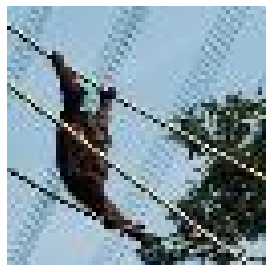

In [ ]:
show_image(denorm(xi));

In [ ]:
# Create dataloader for the training set.
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=8)

In [ ]:
xb, yb = b = next(iter(dltrn))

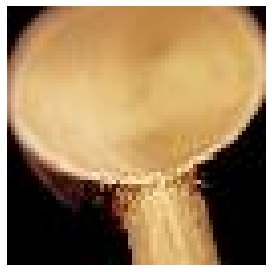

In [ ]:
show_image(denorm(xb[0]));

Now that we have enumerated the wordnet categories, we can use the additional `words.txt` file to grab titles for the keys for each image category. This is a large file with many additional codes, so the title grabbing will need to be selective.

In [ ]:
# This wordnet encoding schema is called `synsets`
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
all_synsets[:20]

[['n00001740', 'entity'],
 ['n00001930', 'physical entity'],
 ['n00002137', 'abstraction, abstract entity'],
 ['n00002452', 'thing'],
 ['n00002684', 'object, physical object'],
 ['n00003553', 'whole, unit'],
 ['n00003993', 'congener'],
 ['n00004258', 'living thing, animate thing'],
 ['n00004475', 'organism, being'],
 ['n00005787', 'benthos'],
 ['n00005930', 'dwarf'],
 ['n00006024', 'heterotroph'],
 ['n00006150', 'parent'],
 ['n00006269', 'life'],
 ['n00006400', 'biont'],
 ['n00006484', 'cell'],
 ['n00007347', 'causal agent, cause, causal agency'],
 ['n00007846', 'person, individual, someone, somebody, mortal, soul'],
 ['n00015388', 'animal, animate being, beast, brute, creature, fauna'],
 ['n00017222', 'plant, flora, plant life']]

In [ ]:
# Filter to synsets which occur in our training data
synsets = {k:v.split(',', maxsplit=1)[0] for k, v in all_synsets if k in id2str}
# Extract titles
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'wooden spoon, beach wagon, convertible, bell pepper, seashore, flagpole, snail, sulphur butterfly, go-kart, dragonfly, organ, sulphur butterfly, bee, pretzel, abacus, brass, beach wagon, chest, cardigan, gazelle'

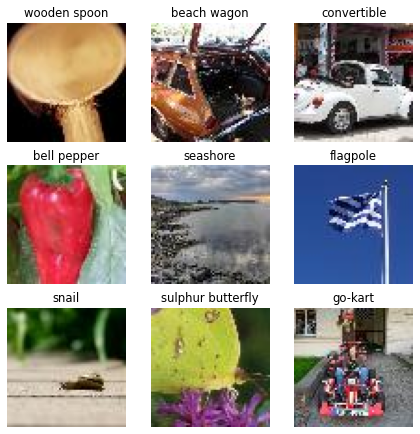

In [ ]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [ ]:
# Load transformed and labelled data onto DataLoader
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

## **Train Basic Model**

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

The standard procedure used for transforming images for super-resolution is `RandomResizeCrop`, but that tends to work poorly with 64x64 images and ends up introducing blurring.

In [ ]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [ ]:
nfs = (32, 64, 128, 256, 512, 1024)

Copying over the code we used to train the FashionMNIST UNet.

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

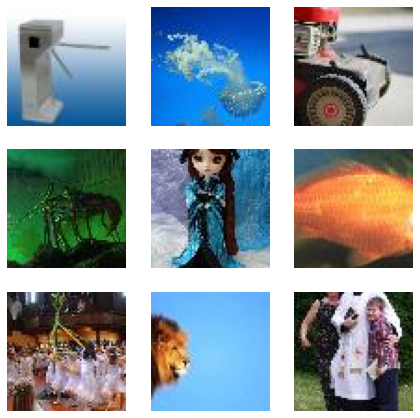

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb, yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


/content/course22p2/miniai/accel.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


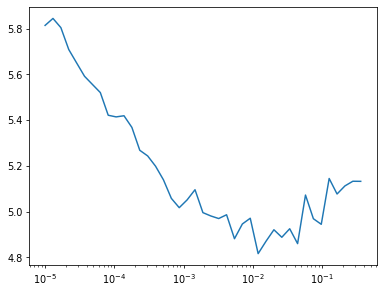

In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)
lr_cbs = [DeviceCB(), augcb, MixedPrecision(), ProgressCB()]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
# Find optimum LR for the UNet model
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [ ]:
epochs = 25
lr = 0.01
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.111,4.408,0,train
0.175,3.888,0,eval
0.220,3.661,1,train
0.232,3.505,1,eval
0.276,3.307,2,train
0.268,3.274,2,eval
0.309,3.070,3,train
0.294,3.145,3,eval
0.344,2.858,4,train
0.333,2.997,4,eval


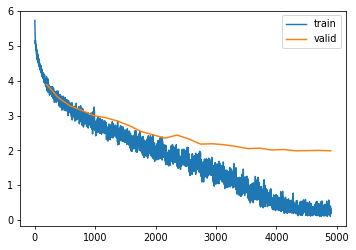

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/imgnet-tiny-basic-25')

## **Training a Deeper Network**

In the last training run, we managed to achieve an accuracy of `57.7%` on our standard ResNets with minimal data augmentation. To improve performance, we can refer to approaches used in [Papers With Code's](https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1) leaderboards.

In addition to the standard architecture, we can add `resblocks` per downsampling layer to increase the depth of the ResNet to nearly 2x.

In [ ]:
# Function to add resblocks with additional depth. Simply goes through the predetermined
# number of blocks and adds resblocks accordingly.
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    # For the last layer, use stride=2 else stride=1 for all other layers.
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [ ]:
# Number of resblocks for downsampling i.e. 9 resblocks in total
# which is basically the sum of nbks
nbks = (3, 2, 2, 1, 1)

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], stride=1, ks=5, act=act, norm=norm)]
    # Replace ResBlock() with res_blocks() for additional depth.
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

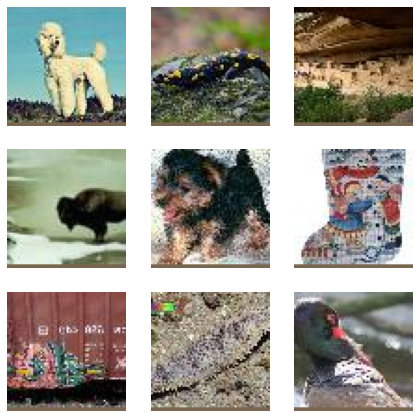

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb, yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 21426800; MFLOPS: 710.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 3, 64, 64)|(512, 32, 64, 64)|28320|115.1|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|206016|209.7|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|525952|134.2|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|2100480|134.2|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


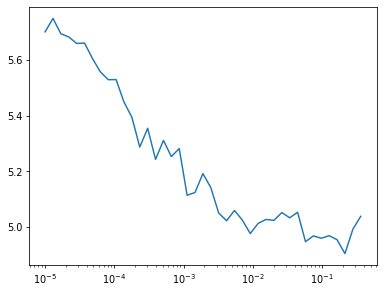

In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)

learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.093,4.485,0,train
0.146,3.964,0,eval
0.214,3.612,1,train
0.228,3.519,1,eval
0.278,3.197,2,train
0.240,3.558,2,eval
0.321,2.939,3,train
0.309,3.076,3,eval
0.357,2.732,4,train
0.335,2.925,4,eval


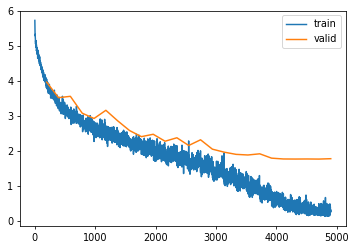

In [ ]:
learn.fit(epochs)

In [ ]:
path_model = Path('models')
path_model.mkdir(exist_ok=True)
torch.save(learn.model, 'models/imgnet-tiny-custom-25')

## **Additional Augmentation**

Following updates to the model architecture, we will add additional augmentation. For this run, we will experiment with an approach called [TrivialAugment](https://arxiv.org/abs/2103.10158) which is:

> a most simple baseline...that outperforms previous methods for almost free. TrivialAugment is parameter-free and only applies a single augmentation to each image.

The paper states that it results in marked performance improvements to image modelling tasks. Techincal details of its application can be found in [Pytorch's documentation](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html).

In [ ]:
del(learn)
clean_mem()

In [ ]:
aug_tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                         T.RandomHorizontalFlip(),
                         T.TrivialAugmentWide())

norm_tfm = T.Normalize(xmean, xstd)
erase_tfm = RandErase()

In [ ]:
from PIL import Image

In [ ]:
# Some of the augmentations in TrivialAugmentWide() require images to be in PIL format.
# So we will both convert images to PIL objects, and carry out augmentations in one simple function.
def tfmx(x, aug=False):
    x = Image.open(x).convert('RGB')
    if aug: x = aug_tfms(x)
    x = TF.to_tensor(x)
    x = norm_tfm(x)
    # Random erase needs to happen after normalization due to handling of 0/1 gaussian noise.
    if aug: x = erase_tfm(x[None])[0]
    return x

In [ ]:
# Augmentations only apply to the training set!
tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

Based on the paper [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027), Kaiming He et al. proposed an updated ResNet which uses **"pre-activation resblocks"**.

For this, we will need to redefine `conv()`, with dual activations in the `_conv_block()`. Activations within the `forward()` function of the `ResBlock()` will be removed.

Finally, `get_dropmodel()` will have an additional activation and normalization i.e.

```
layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
```

The details in these code blocks are highly important and warrant additional scrutiny before implementation.

In [ ]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act:  layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers) #fixed

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1    , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

In [ ]:
class Resblock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
def get_model(): return get_dropmodel(nbks=(4,3,3,2,1), drop=0.1)

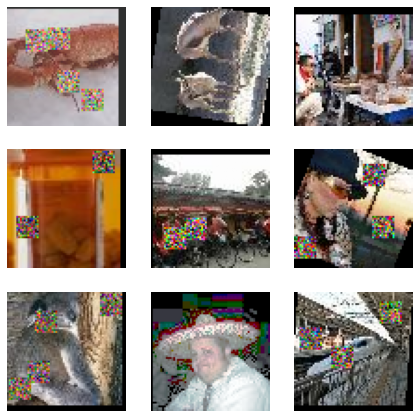

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
epochs = 50
lr = 0.01
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.047,4.896,0,train
0.100,4.364,0,eval
0.125,4.257,1,train
0.189,3.718,1,eval
0.191,3.817,2,train
0.249,3.393,2,eval
0.237,3.519,3,train
0.289,3.153,3,eval
0.277,3.272,4,train
0.309,3.066,4,eval


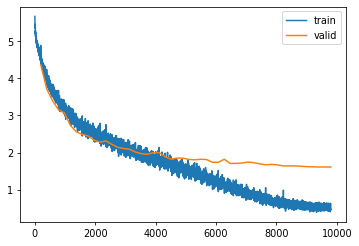

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/imgnet-tiny-trivaug-50')